In [1]:
!pip install datasets
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.7 MB/s eta 0:00:00


In [4]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import load_dataset

In [5]:
from transformers import BertTokenizer, BertForSequenceClassification

model_name = "google-bert/bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
train_dataset = load_dataset('csv', data_files="/content/taskC_train_edited.csv", split="train")
eval_dataset = load_dataset('csv', data_files="/content/taskC_eval_edited.csv")

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [7]:
def tokenize_function(examples):
    return tokenizer(examples["tweet"], padding="max_length", truncation=True)

# Tokenize with parallel processing
tokenized_train = train_dataset.map(tokenize_function, batched=True, num_proc=4)
tokenized_eval = eval_dataset.map(tokenize_function, batched=True, num_proc=4)

Map (num_proc=4):   0%|          | 0/2204 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/473 [00:00<?, ? examples/s]

In [8]:
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_eval.set_format("torch", columns=["input_ids", "attention_mask", "truth_label"])

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,  # Adjust based on GPU memory
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,  # Enable mixed precision training
    gradient_accumulation_steps=2,  # Accumulate gradients over 2 steps
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
)

In [9]:
trainer.train()

# Clear cache after training
torch.cuda.empty_cache()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Train Runtime,Train Samples Per Second,Train Steps Per Second
0,No log,No log,3.091000,153.026000,2.588000
2,No log,No log,3.159000,149.730000,2.532000


In [13]:
trainer.save_model("fine_tuned_model_taskC_gb")  # Save the model
tokenizer.save_pretrained("fine_tuned_model_taskC_gb")

('fine_tuned_model_taskC_gb/tokenizer_config.json',
 'fine_tuned_model_taskC_gb/special_tokens_map.json',
 'fine_tuned_model_taskC_gb/vocab.txt',
 'fine_tuned_model_taskC_gb/added_tokens.json')

In [15]:
model_path="/content/fine_tuned_model_taskC_gb"
model1=BertForSequenceClassification.from_pretrained(model_path)
tokenizer1=BertTokenizer.from_pretrained(model_path)

In [16]:
model1.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [17]:
import pandas as pd
test=pd.read_csv("/content/taskC_test_edited.csv")
test=test.dropna(subset=['tweet'])
test_texts=test['tweet'].tolist()
inputs=tokenizer(test_texts,padding=True,truncation=True,return_tensors="pt")
with torch.no_grad():
  outputs=model1(**inputs)
logits=outputs.logits
predicted_labels=torch.argmax(logits,dim=1)
label_map={0:"individual",1:"organization",2:"community"}
predicted_labels=[label_map[pred.item()]for pred in predicted_labels]
results_df=pd.DataFrame({'predicted_label':predicted_labels},index=test.index)
results_df.to_csv("taskC_test_results.csv",index=True)

In [19]:
pl=pd.read_csv("/content/taskC_test_results.csv")
pl['predicted_label'].value_counts()

,count
predicted_label,
individual,254
organization,215


In [20]:
from sklearn.metrics import classification_report
truth_labels=test['truth_label'].tolist()
predicted_labels=pl['predicted_label'].tolist()
label_map_reverse={v: k for k,v in label_map.items()}
predicted_labels_numeric=[label_map_reverse[label] for label in predicted_labels]
report=classification_report(truth_labels,predicted_labels_numeric)
print(report)

              precision    recall  f1-score   support

           0       0.64      0.72      0.68       226
           1       0.60      0.71      0.65       182
           2       0.00      0.00      0.00        61

    accuracy                           0.62       469
   macro avg       0.41      0.48      0.44       469
weighted avg       0.54      0.62      0.58       469



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


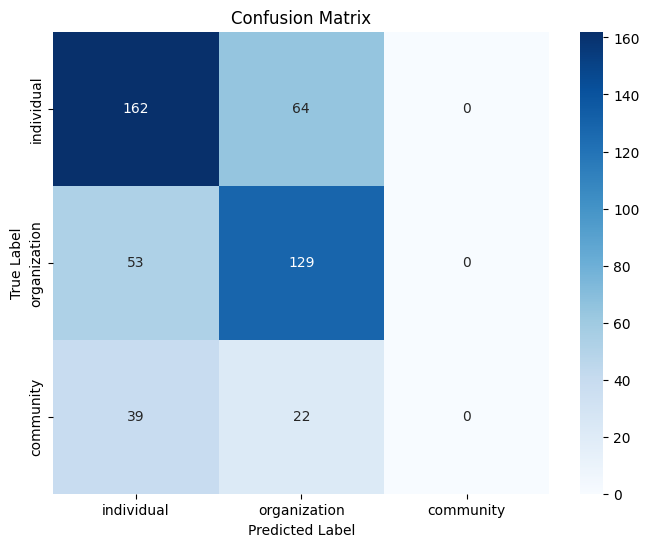

In [21]:
# prompt: confusion matrix

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming truth_labels and predicted_labels_numeric are defined as in the previous code
cm = confusion_matrix(truth_labels, predicted_labels_numeric)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(label_map.values()),
            yticklabels=list(label_map.values()))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [22]:
# prompt: overall f1 score

from sklearn.metrics import f1_score

# Calculate the overall F1 score (macro average)
overall_f1 = f1_score(truth_labels, predicted_labels_numeric, average='macro')
print(f"Overall F1 Score: {overall_f1}")

Overall F1 Score: 0.4416246851385391


In [23]:
# prompt: PR AUC score

import pandas as pd
from sklearn.metrics import precision_recall_curve, auc

# Assuming truth_labels and predicted_labels_numeric are defined as in the previous code
# ... (your existing code)

# Calculate PR AUC for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(3): # Assuming you have 3 classes
    precision[i], recall[i], _ = precision_recall_curve(
        [1 if x == i else 0 for x in truth_labels],
        [1 if x == i else 0 for x in predicted_labels_numeric]
    )
    average_precision[i] = auc(recall[i], precision[i])
    print(f"PR AUC for class {i}: {average_precision[i]}")

PR AUC for class 0: 0.7455349946267944
PR AUC for class 1: 0.7108988026898475
PR AUC for class 2: 0.5650319829424307


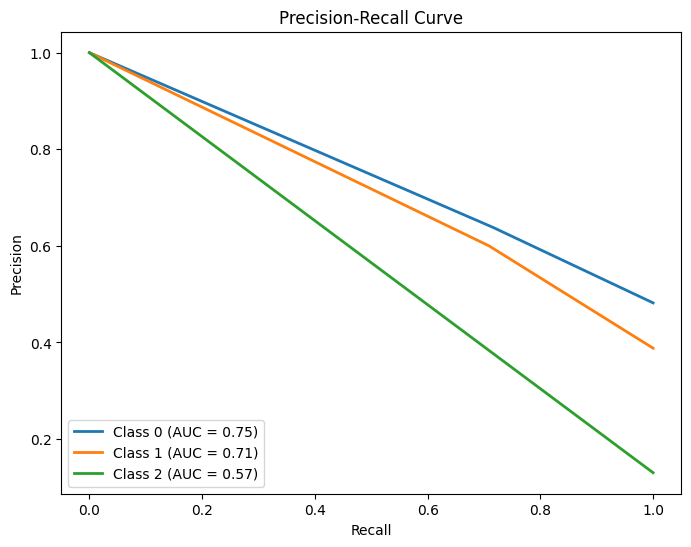

In [24]:
# prompt: plot the PR AUC score and include the score in legend

# Plot the PR AUC for each class
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AUC = {average_precision[i]:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()